<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/vito/STEP_5_BISENET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [1]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [2]:
from google.colab import drive
import os

!git clone -b angelo_albumentations --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 124 (delta 18), reused 6 (delta 6), pack-reused 88 (from 1)
Receiving objects: 100% (124/124), 21.14 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Mounted at /content/drive


In [3]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [4]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extraction check completed!
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [5]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

IGNORE_INDEX = -1

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 21

GAMMA = 0.5

#LR = 0.00053
LR = 0.0003

P = 0.5 # probabilità augmentation

ALPHA_TEACHER = 0.99

THRESHOLD = 0.9

MOMENTUM = 0.85

LOSS_TYPE = "" # "ohem", "ce"

TYPE_WEIGHT = "inverse" # median-frequency | inverse | log

PIXEL_WEIGHT = "tharshold_uniform"


WEIGHT_DECAY= 0.005
NESTEROV = True

# Define and instantiate

### Define BISENetV2

In [6]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as modelzoo

backbone_url = 'https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/backbone_v2.pth'


class ConvBNReLU(nn.Module):

    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1,
                 dilation=1, groups=1, bias=False):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(
                in_chan, out_chan, kernel_size=ks, stride=stride,
                padding=padding, dilation=dilation,
                groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv(x)
        feat = self.bn(feat)
        feat = self.relu(feat)
        return feat


class UpSample(nn.Module):

    def __init__(self, n_chan, factor=2):
        super(UpSample, self).__init__()
        out_chan = n_chan * factor * factor
        self.proj = nn.Conv2d(n_chan, out_chan, 1, 1, 0)
        self.up = nn.PixelShuffle(factor)
        self.init_weight()

    def forward(self, x):
        feat = self.proj(x)
        feat = self.up(feat)
        return feat

    def init_weight(self):
        nn.init.xavier_normal_(self.proj.weight, gain=1.)



class DetailBranch(nn.Module):

    def __init__(self):
        super(DetailBranch, self).__init__()
        self.S1 = nn.Sequential(
            ConvBNReLU(3, 64, 3, stride=2),
            ConvBNReLU(64, 64, 3, stride=1),
        )
        self.S2 = nn.Sequential(
            ConvBNReLU(64, 64, 3, stride=2),
            ConvBNReLU(64, 64, 3, stride=1),
            ConvBNReLU(64, 64, 3, stride=1),
        )
        self.S3 = nn.Sequential(
            ConvBNReLU(64, 128, 3, stride=2),
            ConvBNReLU(128, 128, 3, stride=1),
            ConvBNReLU(128, 128, 3, stride=1),
        )

    def forward(self, x):
        feat = self.S1(x)
        feat = self.S2(feat)
        feat = self.S3(feat)
        return feat


class StemBlock(nn.Module):

    def __init__(self):
        super(StemBlock, self).__init__()
        self.conv = ConvBNReLU(3, 16, 3, stride=2)
        self.left = nn.Sequential(
            ConvBNReLU(16, 8, 1, stride=1, padding=0),
            ConvBNReLU(8, 16, 3, stride=2),
        )
        self.right = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.fuse = ConvBNReLU(32, 16, 3, stride=1)

    def forward(self, x):
        feat = self.conv(x)
        feat_left = self.left(feat)
        feat_right = self.right(feat)
        feat = torch.cat([feat_left, feat_right], dim=1)
        feat = self.fuse(feat)
        return feat


class CEBlock(nn.Module):

    def __init__(self):
        super(CEBlock, self).__init__()
        self.bn = nn.BatchNorm2d(128)
        self.conv_gap = ConvBNReLU(128, 128, 1, stride=1, padding=0)
        #TODO: in paper here is naive conv2d, no bn-relu
        self.conv_last = ConvBNReLU(128, 128, 3, stride=1)

    def forward(self, x):
        feat = torch.mean(x, dim=(2, 3), keepdim=True)
        feat = self.bn(feat)
        feat = self.conv_gap(feat)
        feat = feat + x
        feat = self.conv_last(feat)
        return feat


class GELayerS1(nn.Module):

    def __init__(self, in_chan, out_chan, exp_ratio=6):
        super(GELayerS1, self).__init__()
        mid_chan = in_chan * exp_ratio
        self.conv1 = ConvBNReLU(in_chan, in_chan, 3, stride=1)
        self.dwconv = nn.Sequential(
            nn.Conv2d(
                in_chan, mid_chan, kernel_size=3, stride=1,
                padding=1, groups=in_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
            nn.ReLU(inplace=True), # not shown in paper
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, out_chan, kernel_size=1, stride=1,
                padding=0, bias=False),
            nn.BatchNorm2d(out_chan),
        )
        self.conv2[1].last_bn = True
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.dwconv(feat)
        feat = self.conv2(feat)
        feat = feat + x
        feat = self.relu(feat)
        return feat


class GELayerS2(nn.Module):

    def __init__(self, in_chan, out_chan, exp_ratio=6):
        super(GELayerS2, self).__init__()
        mid_chan = in_chan * exp_ratio
        self.conv1 = ConvBNReLU(in_chan, in_chan, 3, stride=1)
        self.dwconv1 = nn.Sequential(
            nn.Conv2d(
                in_chan, mid_chan, kernel_size=3, stride=2,
                padding=1, groups=in_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
        )
        self.dwconv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, mid_chan, kernel_size=3, stride=1,
                padding=1, groups=mid_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
            nn.ReLU(inplace=True), # not shown in paper
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, out_chan, kernel_size=1, stride=1,
                padding=0, bias=False),
            nn.BatchNorm2d(out_chan),
        )
        self.conv2[1].last_bn = True
        self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_chan, in_chan, kernel_size=3, stride=2,
                    padding=1, groups=in_chan, bias=False),
                nn.BatchNorm2d(in_chan),
                nn.Conv2d(
                    in_chan, out_chan, kernel_size=1, stride=1,
                    padding=0, bias=False),
                nn.BatchNorm2d(out_chan),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.dwconv1(feat)
        feat = self.dwconv2(feat)
        feat = self.conv2(feat)
        shortcut = self.shortcut(x)
        feat = feat + shortcut
        feat = self.relu(feat)
        return feat


class SegmentBranch(nn.Module):

    def __init__(self):
        super(SegmentBranch, self).__init__()
        self.S1S2 = StemBlock()
        self.S3 = nn.Sequential(
            GELayerS2(16, 32),
            GELayerS1(32, 32),
        )
        self.S4 = nn.Sequential(
            GELayerS2(32, 64),
            GELayerS1(64, 64),
        )
        self.S5_4 = nn.Sequential(
            GELayerS2(64, 128),
            GELayerS1(128, 128),
            GELayerS1(128, 128),
            GELayerS1(128, 128),
        )
        self.S5_5 = CEBlock()

    def forward(self, x):
        feat2 = self.S1S2(x)
        feat3 = self.S3(feat2)
        feat4 = self.S4(feat3)
        feat5_4 = self.S5_4(feat4)
        feat5_5 = self.S5_5(feat5_4)
        return feat2, feat3, feat4, feat5_4, feat5_5


class BGALayer(nn.Module):

    def __init__(self):
        super(BGALayer, self).__init__()
        self.left1 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, 128, kernel_size=1, stride=1,
                padding=0, bias=False),
        )
        self.left2 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=2,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        )
        self.right1 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
        )
        self.right2 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, 128, kernel_size=1, stride=1,
                padding=0, bias=False),
        )
        self.up1 = nn.Upsample(scale_factor=4)
        self.up2 = nn.Upsample(scale_factor=4)
        ##TODO: does this really has no relu?
        self.conv = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), # not shown in paper
        )

    def forward(self, x_d, x_s):
        dsize = x_d.size()[2:]
        left1 = self.left1(x_d)
        left2 = self.left2(x_d)
        right1 = self.right1(x_s)
        right2 = self.right2(x_s)
        right1 = self.up1(right1)
        left = left1 * torch.sigmoid(right1)
        right = left2 * torch.sigmoid(right2)
        right = self.up2(right)
        out = self.conv(left + right)
        return out



class SegmentHead(nn.Module):

    def __init__(self, in_chan, mid_chan, n_classes, up_factor=8, aux=True):
        super(SegmentHead, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, 3, stride=1)
        self.drop = nn.Dropout(0.1)
        self.up_factor = up_factor

        out_chan = n_classes
        mid_chan2 = up_factor * up_factor if aux else mid_chan
        up_factor = up_factor // 2 if aux else up_factor
        self.conv_out = nn.Sequential(
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                ConvBNReLU(mid_chan, mid_chan2, 3, stride=1)
                ) if aux else nn.Identity(),
            nn.Conv2d(mid_chan2, out_chan, 1, 1, 0, bias=True),
            nn.Upsample(scale_factor=up_factor, mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        feat = self.conv(x)
        feat = self.drop(feat)
        feat = self.conv_out(feat)
        return feat


class CustomArgMax(torch.autograd.Function):

    @staticmethod
    def forward(ctx, feat_out, dim):
        return feat_out.argmax(dim=dim).int()

    @staticmethod
    def symbolic(g, feat_out, dim: int):
        return g.op('CustomArgMax', feat_out, dim_i=dim)


class BiSeNetV2(nn.Module):

    def __init__(self, n_classes, aux_mode='train'):
        super(BiSeNetV2, self).__init__()
        self.aux_mode = aux_mode
        self.detail = DetailBranch()
        self.segment = SegmentBranch()
        self.bga = BGALayer()

        ## TODO: what is the number of mid chan ?
        self.head = SegmentHead(128, 1024, n_classes, up_factor=8, aux=False)
        if self.aux_mode == 'train':
            self.aux2 = SegmentHead(16, 128, n_classes, up_factor=4)
            self.aux3 = SegmentHead(32, 128, n_classes, up_factor=8)
            self.aux4 = SegmentHead(64, 128, n_classes, up_factor=16)
            self.aux5_4 = SegmentHead(128, 128, n_classes, up_factor=32)

        self.init_weights()

    def forward(self, x):
        size = x.size()[2:]
        feat_d = self.detail(x)
        feat2, feat3, feat4, feat5_4, feat_s = self.segment(x)
        feat_head = self.bga(feat_d, feat_s)

        logits = self.head(feat_head)
        if self.aux_mode == 'train':
            logits_aux2 = self.aux2(feat2)
            logits_aux3 = self.aux3(feat3)
            logits_aux4 = self.aux4(feat4)
            logits_aux5_4 = self.aux5_4(feat5_4)
            return logits, logits_aux2, logits_aux3, logits_aux4, logits_aux5_4
        elif self.aux_mode == 'eval':
            return logits,
        elif self.aux_mode == 'pred':
            #  pred = logits.argmax(dim=1)
            pred = CustomArgMax.apply(logits, 1)
            return pred
        else:
            raise NotImplementedError

    def init_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(module.weight, mode='fan_out')
                if not module.bias is None: nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.modules.batchnorm._BatchNorm):
                if hasattr(module, 'last_bn') and module.last_bn:
                    nn.init.zeros_(module.weight)
                else:
                    nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
        print("Loading weights...")
        self.load_pretrain()
        print("Loaded weights!!")


    def load_pretrain(self):
        state = modelzoo.load_url(backbone_url)
        for name, child in self.named_children():
            if name in state.keys():
                child.load_state_dict(state[name], strict=True)

    def get_params(self):
        def add_param_to_list(mod, wd_params, nowd_params):
            for param in mod.parameters():
                if param.dim() == 1:
                    nowd_params.append(param)
                elif param.dim() == 4:
                    wd_params.append(param)
                else:
                    print(name)

        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            if 'head' in name or 'aux' in name:
                add_param_to_list(child, lr_mul_wd_params, lr_mul_nowd_params)
            else:
                add_param_to_list(child, wd_params, nowd_params)
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params


# Dataset & dataloader

## Dataset definition

In [7]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, target=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.target = target

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        # if the dataset is a target dataset, does not return the mask
        if self.target == True:
          return image, boundaries_tensor
        return image, mask, boundaries_tensor

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2

resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])

# the best augmentation from previous step is chosen
augment =  A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=P)

In [9]:
def extract_boundary_mask(mask):
    if isinstance(mask, torch.Tensor):
        mask_np = mask.squeeze().cpu().numpy()  # Assicura che sia [H, W]
    else:
        mask_np = np.array(mask)

    mask_np = mask_np.astype(np.uint8)

    edge = cv2.Canny(mask_np, 0.1, 0.2)

    kernel = np.ones((3, 3), np.uint8)
    edge = edge[6:-6, 6:-6]
    edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
    boundaries = cv2.dilate(edge, kernel, iterations=1)
    boundaries = (boundaries > 50).astype(np.float32)

    boundaries_tensor = torch.from_numpy(boundaries).unsqueeze(0)  # shape: [1, H, W]
    return boundaries_tensor


## Dataset instantiation

In [10]:
# Create dataset objects

# TRAINING DATASETS
source_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                    transform=resize_transform)


target_dataset = SegmentationDataset(TRAINING_PATH_RURAL + "/images_png", TRAINING_PATH_RURAL + "/masks_png",
                                    transform=resize_transform, target=True)

# EVALUATION DATASET

val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)

In [11]:
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

# Supponiamo tu abbia un DataLoader con le etichette GT (y) nei batch
class_counts = torch.zeros(NUM_CLASSES)

for (images, labels, _) in tqdm(DataLoader(source_dataset, batch_size=BATCH_SIZE)):
    for c in range(NUM_CLASSES):
        class_counts[c] += torch.sum(labels == c)

# Converti in numpy
class_counts = class_counts.numpy()
total_pixels = np.sum(class_counts)
frequencies = class_counts / total_pixels

if TYPE_WEIGHT == "inverse":
  #Inverse frequency
  class_weights = 1.0 / (frequencies + 1e-8)
elif TYPE_WEIGHT == "median-frequency":
  #Median frequency balancing
  median = np.median(frequencies)
  class_weights = median / (frequencies + 1e-8)
elif TYPE_WEIGHT == "log":
  #Log smoothing
  class_weights = 1.0 / np.log(1.02 + frequencies)

print(class_weights)



100%|██████████| 73/73 [01:02<00:00,  1.17it/s]

[ 2.063954  4.717028 10.776062 26.797655 13.217381 12.630906 53.904175]


## Loader instantiation

In [12]:
# Create DataLoaders

# TRAINING DATALOADERS
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# EVALUATION DATALOADERS

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# enumerate dataloaders
source_loader_iter = enumerate(source_loader)
target_loader_iter = enumerate(target_loader)


### Instantiate model

In [13]:
#istanziare BISENET e applicare i pesi
model = BiSeNetV2(NUM_CLASSES)


Loading weights...


Downloading: "https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/backbone_v2.pth" to /root/.cache/torch/hub/checkpoints/backbone_v2.pth
100%|██████████| 8.34M/8.34M [00:00<00:00, 331MB/s]


Loaded weights!!


# Training Phase

## Define loss functions

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# # Extra Semantic Loss (Classica CrossEntropy Loss)
# class CrossEntropyLoss(nn.Module):
#     def __init__(self, num_outputs, weight=None, balance_weights=[0.4, 1.0], sb_weights=1.0):
#         super(CrossEntropyLoss, self).__init__()
#         self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=IGNORE_INDEX)
#         self.num_outputs = num_outputs
#         self.balance_weights = balance_weights
#         self.sb_weights = sb_weights

#     def _forward(self, pred, target):
#         return self.loss(pred, target)

#     def forward(self, score, target):
#         if self.num_outputs == 1:
#             score = [score]

#         if len(self.balance_weights) == len(score):
#             return sum([w * self._forward(x, target) for (w, x) in zip(self.balance_weights, score)])
#         elif len(score) == 1:
#             return self.sb_weights * self._forward(score[0], target)
#         else:
#             raise ValueError("lengths of prediction and target are not identical!")

# class OhemCrossEntropy(nn.Module):
#     def __init__(self, thres=0.7, min_kept=26_000, balance_weights=[0.4, 1.0], sb_weights=1.0, weight=None):
#         super(OhemCrossEntropy, self).__init__()
#         self.thresh = thres
#         self.min_kept = max(1, min_kept)
#         self.ignore_label = IGNORE_INDEX
#         self.balance_weights = balance_weights
#         self.sb_weights = sb_weights
#         self.criterion = nn.CrossEntropyLoss(
#             weight=weight,
#             ignore_index=self.ignore_label,
#             reduction='none'
#         )

#     def _ce_forward(self, score, target):
#         loss = self.criterion(score, target)
#         return loss

#     def _ohem_forward(self, score, target, **kwargs):
#         pred = F.softmax(score, dim=1)
#         pixel_losses = self.criterion(score, target).contiguous().view(-1)
#         mask = target.contiguous().view(-1) != self.ignore_label

#         tmp_target = target.clone()
#         tmp_target[tmp_target == self.ignore_label] = 0
#         pred = pred.gather(1, tmp_target.unsqueeze(1))
#         pred, ind = pred.contiguous().view(-1,)[mask].contiguous().sort()
#         min_value = pred[min(self.min_kept, pred.numel() - 1)]
#         threshold = max(min_value, self.thresh)

#         pixel_losses = pixel_losses[mask][ind]
#         pixel_losses = pixel_losses[pred < threshold]
#         return pixel_losses.mean()

#     def forward(self, score, target):
#         if not (isinstance(score, list) or isinstance(score, tuple)):
#             score = [score]

#         if len(self.balance_weights) == len(score):
#             functions = [self._ce_forward] * \
#                 (len(self.balance_weights) - 1) + [self._ohem_forward]
#             return sum([
#                 w * func(x, target)
#                 for (w, x, func) in zip(self.balance_weights, score, functions)
#             ])

#         elif len(score) == 1:
#             return self.sb_weights * self._ohem_forward(score[0], target)

#         else:
#             raise ValueError("lengths of prediction and target are not identical!")



# LOSS BISENET
class OhemCELoss(nn.Module):

    def __init__(self, thresh, lb_ignore=255):
        super(OhemCELoss, self).__init__()
        self.thresh = -torch.log(torch.tensor(thresh, requires_grad=False, dtype=torch.float)).cuda()
        self.lb_ignore = lb_ignore
        self.criteria = nn.CrossEntropyLoss(ignore_index=lb_ignore, reduction='none')

    def forward(self, logits, labels):
        n_min = labels[labels != self.lb_ignore].numel() // 16
        loss = self.criteria(logits, labels).view(-1)
        loss_hard = loss[loss > self.thresh]
        if loss_hard.numel() < n_min:
            loss_hard, _ = loss.topk(n_min)
        return torch.mean(loss_hard)


In [15]:
class CrossEntropyLoss2dPixelWiseWeighted(nn.Module):
    def __init__(self, weight=None, ignore_index=250, reduction='none'):
        super(CrossEntropyLoss2dPixelWiseWeighted, self).__init__()
        self.CE =  nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target, pixelWiseWeight):
        loss = self.CE(output, target)
        loss = torch.mean(loss * pixelWiseWeight)
        return loss

## Upscaling function

In [16]:
import torch.nn.functional as F

def Upscaling(outputs, boundary_mask, model):
    """Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
    Quindi passiamo da 64 x 64 della rete a 512 x 512"""

    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)
    if model.augment:
        pred_p, pred_main, boundary_head = outputs  # P, I, D branches
    else:
        pred_p = None
        pred_main = outputs
        boundary_head = None  # Nessuna branch D se augment=False

    return pred_p, pred_main, boundary_head

## Instantiate discriminator, optimizers and schedulers

In [17]:
from torch.optim.lr_scheduler import LambdaLR, SequentialLR, StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=GAMMA, patience=3, threshold=0.01)

if TYPE_WEIGHT == "median-frequency" or TYPE_WEIGHT == "inverse" or TYPE_WEIGHT == "log":
  loss_fn = OhemCELoss(thresh=0.8, lb_ignore = IGNORE_INDEX)
  mix_loss = CrossEntropyLoss2dPixelWiseWeighted(ignore_index = IGNORE_INDEX, weight = torch.tensor(class_weights).cuda())
else:
  loss_fn = OhemCELoss(thresh=0.8, lb_ignore = IGNORE_INDEX)
  mix_loss = CrossEntropyLoss2dPixelWiseWeighted(ignore_index = IGNORE_INDEX, weight = None)

print(device)

print(len(target_loader))
print(len(source_loader))

cuda
86
73


# Definition ema model

In [18]:
def create_ema_model(model):
    """Returns a new model that is used to generate pseudo-labels"""

    ema_model = BiSeNetV2(NUM_CLASSES)

    for param in ema_model.parameters():
        param.detach_()
    mp = list(model.parameters())
    mcp = list(ema_model.parameters())
    n = len(mp)
    for i in range(0, n):
        mcp[i].data[:] = mp[i].data[:].clone()

    return ema_model


def update_ema_variables(ema_model, model, alpha_teacher, iteration):
    # Use the "true" average until the exponential average is more correct
    alpha_teacher = min(1 - 1 / (iteration + 1), alpha_teacher)

    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        #ema_param.data.mul_(alpha).add_(1 - alpha, param.data)
        ema_param.data[:] = alpha_teacher * ema_param[:].data[:] + (1 - alpha_teacher) * param[:].data[:]
    return ema_model

In [19]:
def generate_class_mask(pred, classes):
    pred, classes = torch.broadcast_tensors(pred.unsqueeze(0), classes.unsqueeze(1).unsqueeze(2))
    N = pred.eq(classes).sum(0)
    return N

In [20]:
def oneMix(mask, data = None, target = None):
    #Mix
    if not (data is None):
        stackedMask0, _ = torch.broadcast_tensors(mask[0], data[0])
        data = (stackedMask0*data[0]+(1-stackedMask0)*data[1]).unsqueeze(0)
    if not (target is None):
        stackedMask0, _ = torch.broadcast_tensors(mask[0], target[0])
        target = (stackedMask0*target[0]+(1-stackedMask0)*target[1]).unsqueeze(0)
    return data, target

In [21]:
def strong_transform(target, masks_mix, aug = None, data = None):
    data, target = oneMix(masks_mix, data, target)

    if data is not None:
      data_np = data.squeeze(0).cpu().numpy()
    target_np = target.squeeze(0).cpu().numpy()

    if data is not None:
      data_np = np.transpose(data_np, (1, 2, 0))
    target_np = np.transpose(target_np, (1, 2, 0))

    if data is not None:
      augmented = aug(image=data_np, mask=target_np)

      data = augmented['image']
      target = augmented['mask']

      data = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
      target = torch.from_numpy(target).squeeze(-1).unsqueeze(0)  # (1, H, W)
    else:
      target = torch.from_numpy(target_np).squeeze(-1).unsqueeze(0)  # (1, H, W)
      return None, target

    return data, target

## Train

In [22]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU
import matplotlib.pyplot as plt

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

model.to(device)

ema_model = create_ema_model(model)
ema_model.to(device)

num_classes = 7
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)

num_aux_heads = 4
criteria_aux = [OhemCELoss(0.8, IGNORE_INDEX) for _ in range(num_aux_heads)]

criteria_aux_mix = [CrossEntropyLoss2dPixelWiseWeighted(ignore_index = IGNORE_INDEX, weight = torch.tensor(class_weights).cuda()) for _ in range(num_aux_heads)]

for epoch in range(EPOCHS):
    print(scheduler.get_last_lr())
    loss_raw_value = 0
    total_train_samples = 0

    model.train()
    ema_model.train()

    train_loader = zip(source_loader, target_loader)
    num_batches = min(len(source_loader), len(target_loader))

    pbar = tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1} [Training]")

    for i, (source_batch, target_batch) in pbar:
        optimizer.zero_grad()

        X_source, y_source, _ = source_batch
        X_source, y_source = X_source.to(device), y_source.to(device)

        X_target, _ = target_batch
        X_target = X_target.to(device)

        outputs_s = model(X_source)

        logits_labeled, *logits_aux_labeled  = outputs_s

        loss_pre_labled = loss_fn(logits_labeled, y_source)
        loss_aux_labeled = [crit(lgt, y_source) for crit, lgt in zip(criteria_aux, logits_aux_labeled)]
        loss_labeled = loss_pre_labled + sum(loss_aux_labeled)

        outputs_t = ema_model(X_target)

        logits_unlabeled, *logits_aux_unlabeled  = outputs_t

        probs_t = torch.softmax(logits_unlabeled.detach(), dim=1)

        max_probs, pseudo_labels = torch.max(probs_t, dim=1)

        MixMasks = []

        for image_i in range(X_source.shape[0]): # Per ogni immagine source stiamo andando ad estrarre delle classi prese in modo random
          classes = torch.unique(y_source[image_i])
          classes = classes[classes!=-1]
          nclasses = classes.shape[0]

          classes = (classes[torch.Tensor(np.random.choice(nclasses, int((nclasses+nclasses%2)/2),replace=False)).long()]).cuda()

          MixMask = generate_class_mask(y_source[image_i], classes).unsqueeze(0).cuda()
          MixMasks.append(MixMask)

        mixed_imgs = []
        mixed_labels = []
        mixed_boundary_masks = []

        for image_i in range(X_source.shape[0]):
          data = torch.cat((X_source[image_i].unsqueeze(0), X_target[image_i].unsqueeze(0)))
          labels = torch.cat((y_source[image_i].unsqueeze(0), pseudo_labels[image_i].unsqueeze(0)))

          data, mask = strong_transform(
              aug=augment,
              data=data,
              target=labels,
              masks_mix=[MixMasks[image_i]]
          )

          mixed_imgs.append(data)
          mixed_labels.append(mask)

        # if i == 0:
        #   fig, axs = plt.subplots(2, 3, figsize=(24, 10))

        #   for j in range(2):
        #     axs[j, 0].imshow(mixed_imgs[j].squeeze().permute(1, 2, 0).cpu().detach().numpy())
        #     axs[j, 0].set_title("IMG")
        #     axs[j, 0].axis('off')

        #     axs[j, 1].imshow(mixed_labels[j].permute(1, 2, 0).cpu().detach().numpy())
        #     axs[j, 1].set_title("Labels")
        #     axs[j, 1].axis('off')

        #     axs[j, 2].imshow(mixed_boundary_masks[j].permute(1, 2, 0).cpu().detach().numpy())
        #     axs[j, 2].set_title("Boundary")
        #     axs[j, 2].axis('off')

        #   plt.tight_layout()
        #   plt.show()


        #Mi ricostruisce il batch completo da una lista di singole immagini e label mescolate (quindi con shape [1, C, H, W]) in [BATCH_SIZE, C, H, W]
        inputs_mix = torch.cat(mixed_imgs, dim=0).to(device)
        targets_mix = torch.cat(mixed_labels, dim=0).to(device)

        outputs_mix = model(inputs_mix)

        logits_mix, *logits_aux_mix = outputs_mix

        #---------------------------------
        if PIXEL_WEIGHT == "threshold_uniform":
          unlabeled_weight = torch.sum(max_probs.ge(THRESHOLD).long() == 1).item() / np.size(np.array(targets_mix.cpu()))
          pixelWiseWeight = unlabeled_weight * torch.ones(max_probs.shape).cuda()
        else:
          pixelWiseWeight = max_probs.ge(THRESHOLD).float().cuda()

        onesWeights = torch.ones((pixelWiseWeight.shape)).cuda()

        pixelWiseWeight_mix = []

        for image_i in range(X_source.shape[0]):
            weights_pair = torch.cat((onesWeights[image_i].unsqueeze(0), pixelWiseWeight[image_i].unsqueeze(0)))

            _, mixed_weights = strong_transform(
                target=weights_pair,
                masks_mix=[MixMasks[image_i]]
            )

            pixelWiseWeight_mix.append(mixed_weights)

        pixelWiseWeight_mix = torch.cat(pixelWiseWeight_mix, dim=0).to(device)  # [B, H, W]

        loss_pre_mix = mix_loss(logits_mix, targets_mix, pixelWiseWeight_mix)
        loss_aux_mix = [crit(lgt, y_source, pixelWiseWeight_mix) for crit, lgt in zip(criteria_aux_mix, logits_aux_mix)]
        loss_seg_mix = loss_pre_mix + sum(loss_aux_labeled)


        #---------------------------------------

        loss_overall = loss_seg_mix + loss_labeled

        loss_overall.backward()
        optimizer.step()

        ema_model = update_ema_variables(ema_model = ema_model, model = model, alpha_teacher=ALPHA_TEACHER, iteration=(epoch * num_batches + i))

        loss_raw_value += loss_overall.item()
        total_train_samples += X_target.size(0)

        pbar.set_postfix({
            "Loss_seg": f"{loss_raw_value / (i+1):.4f}",
        })

    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary")
    print(f"  → Segmentation Source Loss (RAW) : {loss_raw_value / total_train_samples:.4f}")

    # ---------------------- VALIDATION ----------------------

    model.eval()
    val_loss = 0
    miou_classes.reset()
    total_val_samples = 0

    with torch.inference_mode():
        pbar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1} [Validation]")

        for batch, (X_val, y_val, boundary_mask) in pbar_val:
            X_val, y_val, boundary_mask = X_val.to(device), y_val.to(device), boundary_mask.to(device)

            outputs = model(X_val)
            logits, *_ = outputs

            loss = loss_fn(logits, y_val)

            val_loss += loss.item()
            total_val_samples += X_val.size(0)

            preds = logits.argmax(dim=1)
            valid_mask = (y_val >= 0) & (y_val < num_classes)
            preds_flat = preds[valid_mask]
            targets_flat = y_val[valid_mask]

            miou_classes.update(preds_flat, targets_flat)

            pbar_val.set_postfix({
                "Val_Loss": f"{val_loss / (batch+1):.4f}",
                "mIoU": f"{miou_classes.compute().mean():.4f}"
            })

    avg_val_loss = val_loss / total_val_samples
    miou_per_class = miou_classes.compute()
    miou = miou_per_class.mean()

    print(f"\n→ Validation Loss: {avg_val_loss:.4f}")
    print(f"→ Overall mIoU: {miou:.4f}")
    for i, iou in enumerate(miou_per_class):
        class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
        print(f"  → {class_name} IoU: {iou:.4f}")

    scheduler.step(miou)


Loading weights...
Loaded weights!!
[0.0003]


Epoch 1 [Training]: 100%|██████████| 73/73 [00:41<00:00,  1.77it/s, Loss_seg=94.8405]


Epoch 1/20 Summary
  → Segmentation Source Loss (RAW) : 5.9275



Epoch 1 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.35it/s, Val_Loss=10.6545, mIoU=0.1428]


→ Validation Loss: 0.6659
→ Overall mIoU: 0.1428
  → background IoU: 0.0107
  → building IoU: 0.0973
  → road IoU: 0.2078
  → water IoU: 0.2787
  → barren IoU: 0.1386
  → forest IoU: 0.0223
  → agriculture IoU: 0.2442
[0.0003]



Epoch 2 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.81it/s, Loss_seg=45.2670]


Epoch 2/20 Summary
  → Segmentation Source Loss (RAW) : 2.8292



Epoch 2 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.35it/s, Val_Loss=4.7175, mIoU=0.1735]


→ Validation Loss: 0.2948
→ Overall mIoU: 0.1735
  → background IoU: 0.0939
  → building IoU: 0.1542
  → road IoU: 0.2064
  → water IoU: 0.4514
  → barren IoU: 0.0727
  → forest IoU: 0.0168
  → agriculture IoU: 0.2189
[0.0003]



Epoch 3 [Training]: 100%|██████████| 73/73 [00:39<00:00,  1.85it/s, Loss_seg=34.0246]


Epoch 3/20 Summary
  → Segmentation Source Loss (RAW) : 2.1265



Epoch 3 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.37it/s, Val_Loss=3.7570, mIoU=0.1691]


→ Validation Loss: 0.2348
→ Overall mIoU: 0.1691
  → background IoU: 0.1441
  → building IoU: 0.2231
  → road IoU: 0.1346
  → water IoU: 0.4277
  → barren IoU: 0.0976
  → forest IoU: 0.0399
  → agriculture IoU: 0.1164
[0.0003]



Epoch 4 [Training]: 100%|██████████| 73/73 [00:39<00:00,  1.83it/s, Loss_seg=28.5917]


Epoch 4/20 Summary
  → Segmentation Source Loss (RAW) : 1.7870



Epoch 4 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.35it/s, Val_Loss=2.5050, mIoU=0.2228]


→ Validation Loss: 0.1566
→ Overall mIoU: 0.2228
  → background IoU: 0.2438
  → building IoU: 0.2458
  → road IoU: 0.2168
  → water IoU: 0.4548
  → barren IoU: 0.1241
  → forest IoU: 0.0143
  → agriculture IoU: 0.2598
[0.0003]



Epoch 5 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.81it/s, Loss_seg=24.4249]


Epoch 5/20 Summary
  → Segmentation Source Loss (RAW) : 1.5266



Epoch 5 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.35it/s, Val_Loss=2.9505, mIoU=0.2326]


→ Validation Loss: 0.1844
→ Overall mIoU: 0.2326
  → background IoU: 0.0541
  → building IoU: 0.3423
  → road IoU: 0.2387
  → water IoU: 0.5242
  → barren IoU: 0.1170
  → forest IoU: 0.0257
  → agriculture IoU: 0.3264
[0.0003]



Epoch 6 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.81it/s, Loss_seg=22.1181]


Epoch 6/20 Summary
  → Segmentation Source Loss (RAW) : 1.3824



Epoch 6 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.35it/s, Val_Loss=2.7182, mIoU=0.2428]


→ Validation Loss: 0.1699
→ Overall mIoU: 0.2428
  → background IoU: 0.0808
  → building IoU: 0.3622
  → road IoU: 0.2420
  → water IoU: 0.5428
  → barren IoU: 0.1172
  → forest IoU: 0.0251
  → agriculture IoU: 0.3294
[0.0003]



Epoch 7 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.82it/s, Loss_seg=20.3360]


Epoch 7/20 Summary
  → Segmentation Source Loss (RAW) : 1.2710



Epoch 7 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.37it/s, Val_Loss=2.3132, mIoU=0.2325]


→ Validation Loss: 0.1446
→ Overall mIoU: 0.2325
  → background IoU: 0.1272
  → building IoU: 0.2836
  → road IoU: 0.2319
  → water IoU: 0.5175
  → barren IoU: 0.1280
  → forest IoU: 0.0319
  → agriculture IoU: 0.3071
[0.0003]



Epoch 8 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.81it/s, Loss_seg=19.4637]


Epoch 8/20 Summary
  → Segmentation Source Loss (RAW) : 1.2165



Epoch 8 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.38it/s, Val_Loss=2.2240, mIoU=0.2347]


→ Validation Loss: 0.1390
→ Overall mIoU: 0.2347
  → background IoU: 0.1283
  → building IoU: 0.2996
  → road IoU: 0.2053
  → water IoU: 0.5463
  → barren IoU: 0.1259
  → forest IoU: 0.0360
  → agriculture IoU: 0.3014
[0.0003]



Epoch 9 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.82it/s, Loss_seg=18.5020]


Epoch 9/20 Summary
  → Segmentation Source Loss (RAW) : 1.1564



Epoch 9 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.34it/s, Val_Loss=2.3289, mIoU=0.2536]


→ Validation Loss: 0.1456
→ Overall mIoU: 0.2536
  → background IoU: 0.1158
  → building IoU: 0.3379
  → road IoU: 0.2536
  → water IoU: 0.5511
  → barren IoU: 0.1379
  → forest IoU: 0.0409
  → agriculture IoU: 0.3379
[0.0003]



Epoch 10 [Training]: 100%|██████████| 73/73 [00:39<00:00,  1.83it/s, Loss_seg=18.0892]


Epoch 10/20 Summary
  → Segmentation Source Loss (RAW) : 1.1306



Epoch 10 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.34it/s, Val_Loss=2.0743, mIoU=0.2254]


→ Validation Loss: 0.1296
→ Overall mIoU: 0.2254
  → background IoU: 0.1344
  → building IoU: 0.2160
  → road IoU: 0.2476
  → water IoU: 0.5206
  → barren IoU: 0.1027
  → forest IoU: 0.0462
  → agriculture IoU: 0.3099
[0.0003]



Epoch 11 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.82it/s, Loss_seg=17.5618]


Epoch 11/20 Summary
  → Segmentation Source Loss (RAW) : 1.0976



Epoch 11 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.37it/s, Val_Loss=2.0113, mIoU=0.2497]


→ Validation Loss: 0.1257
→ Overall mIoU: 0.2497
  → background IoU: 0.1890
  → building IoU: 0.3107
  → road IoU: 0.2355
  → water IoU: 0.5470
  → barren IoU: 0.1209
  → forest IoU: 0.0352
  → agriculture IoU: 0.3095
[0.0003]



Epoch 12 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.82it/s, Loss_seg=17.0688]


Epoch 12/20 Summary
  → Segmentation Source Loss (RAW) : 1.0668



Epoch 12 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s, Val_Loss=1.9480, mIoU=0.2558]


→ Validation Loss: 0.1218
→ Overall mIoU: 0.2558
  → background IoU: 0.2290
  → building IoU: 0.3328
  → road IoU: 0.2175
  → water IoU: 0.5453
  → barren IoU: 0.1282
  → forest IoU: 0.0378
  → agriculture IoU: 0.3003
[0.0003]



Epoch 13 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.79it/s, Loss_seg=16.4839]


Epoch 13/20 Summary
  → Segmentation Source Loss (RAW) : 1.0302



Epoch 13 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.32it/s, Val_Loss=2.0760, mIoU=0.2496]


→ Validation Loss: 0.1298
→ Overall mIoU: 0.2496
  → background IoU: 0.2060
  → building IoU: 0.3056
  → road IoU: 0.2449
  → water IoU: 0.5346
  → barren IoU: 0.1524
  → forest IoU: 0.0332
  → agriculture IoU: 0.2705
[0.00015]



Epoch 14 [Training]: 100%|██████████| 73/73 [00:39<00:00,  1.83it/s, Loss_seg=16.3640]


Epoch 14/20 Summary
  → Segmentation Source Loss (RAW) : 1.0227



Epoch 14 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s, Val_Loss=1.9847, mIoU=0.2595]


→ Validation Loss: 0.1240
→ Overall mIoU: 0.2595
  → background IoU: 0.2147
  → building IoU: 0.3022
  → road IoU: 0.2496
  → water IoU: 0.5460
  → barren IoU: 0.1353
  → forest IoU: 0.0368
  → agriculture IoU: 0.3316
[0.00015]



Epoch 15 [Training]: 100%|██████████| 73/73 [00:39<00:00,  1.83it/s, Loss_seg=16.1051]


Epoch 15/20 Summary
  → Segmentation Source Loss (RAW) : 1.0066



Epoch 15 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s, Val_Loss=1.6996, mIoU=0.2714]


→ Validation Loss: 0.1062
→ Overall mIoU: 0.2714
  → background IoU: 0.2887
  → building IoU: 0.3155
  → road IoU: 0.2381
  → water IoU: 0.5647
  → barren IoU: 0.1322
  → forest IoU: 0.0476
  → agriculture IoU: 0.3128
[0.00015]



Epoch 16 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.79it/s, Loss_seg=16.1188]


Epoch 16/20 Summary
  → Segmentation Source Loss (RAW) : 1.0074



Epoch 16 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.32it/s, Val_Loss=1.8518, mIoU=0.2612]


→ Validation Loss: 0.1157
→ Overall mIoU: 0.2612
  → background IoU: 0.2352
  → building IoU: 0.3154
  → road IoU: 0.2458
  → water IoU: 0.5596
  → barren IoU: 0.1275
  → forest IoU: 0.0401
  → agriculture IoU: 0.3044
[0.00015]



Epoch 17 [Training]: 100%|██████████| 73/73 [00:41<00:00,  1.78it/s, Loss_seg=15.9587]


Epoch 17/20 Summary
  → Segmentation Source Loss (RAW) : 0.9974



Epoch 17 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.30it/s, Val_Loss=1.7790, mIoU=0.2695]


→ Validation Loss: 0.1112
→ Overall mIoU: 0.2695
  → background IoU: 0.3023
  → building IoU: 0.3427
  → road IoU: 0.2514
  → water IoU: 0.5583
  → barren IoU: 0.1209
  → forest IoU: 0.0484
  → agriculture IoU: 0.2628
[0.00015]



Epoch 18 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.78it/s, Loss_seg=15.7147]


Epoch 18/20 Summary
  → Segmentation Source Loss (RAW) : 0.9822



Epoch 18 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.29it/s, Val_Loss=2.0168, mIoU=0.2646]


→ Validation Loss: 0.1261
→ Overall mIoU: 0.2646
  → background IoU: 0.2439
  → building IoU: 0.3426
  → road IoU: 0.2415
  → water IoU: 0.5665
  → barren IoU: 0.1463
  → forest IoU: 0.0418
  → agriculture IoU: 0.2695
[0.00015]



Epoch 19 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.80it/s, Loss_seg=16.0364]


Epoch 19/20 Summary
  → Segmentation Source Loss (RAW) : 1.0023



Epoch 19 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.31it/s, Val_Loss=2.1457, mIoU=0.2567]


→ Validation Loss: 0.1341
→ Overall mIoU: 0.2567
  → background IoU: 0.1928
  → building IoU: 0.3398
  → road IoU: 0.2601
  → water IoU: 0.5335
  → barren IoU: 0.1328
  → forest IoU: 0.0422
  → agriculture IoU: 0.2959
[7.5e-05]



Epoch 20 [Training]: 100%|██████████| 73/73 [00:40<00:00,  1.80it/s, Loss_seg=15.5577]


Epoch 20/20 Summary
  → Segmentation Source Loss (RAW) : 0.9724



Epoch 20 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.32it/s, Val_Loss=1.7002, mIoU=0.2686]


→ Validation Loss: 0.1063
→ Overall mIoU: 0.2686
  → background IoU: 0.2893
  → building IoU: 0.3272
  → road IoU: 0.2199
  → water IoU: 0.5628
  → barren IoU: 0.1478
  → forest IoU: 0.0422
  → agriculture IoU: 0.2910


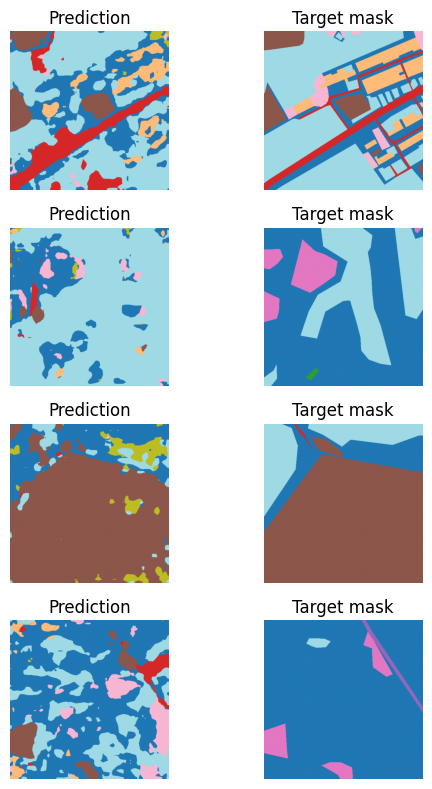

tensor(0.2686, device='cuda:0')
Epoch 20/20 | Validation Loss: 0.10626218371814297 | mIoU: 0.26859134435653687 | Total validation samples seen: 992
  → background IoU: 0.2893
  → building IoU: 0.3272
  → road IoU: 0.2199
  → water IoU: 0.5628
  → barren IoU: 0.1478
  → forest IoU: 0.0422
  → agriculture IoU: 0.2910


In [29]:
# ****************************** Validazione ******************************
from torchmetrics.segmentation import MeanIoU

num_classes = 7
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)

model.eval()
val_loss = 0
miou_classes.reset()
total_val_samples = 0

with torch.inference_mode():
    for batch, (X_val, y_val, boundary_mask) in enumerate(val_loader):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        output, *_ = model(X_val)



        if batch == 0:
          fig, axs = plt.subplots(4, 2, figsize=(6, 8))

          for j in range(4):

            axs[j, 0].imshow(output[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
            axs[j, 0].set_title("Prediction")
            axs[j, 0].axis('off')

            axs[j, 1].imshow(y_val[j].cpu().detach().numpy(), cmap='tab20')
            axs[j, 1].set_title("Target mask")
            axs[j, 1].axis('off')

          plt.tight_layout()
          plt.show()

        # Calcola la loss
        loss = loss_fn(output, y_val)
        val_loss += loss.item()

        total_val_samples += X_val.size(0)

        # Calcola le predizioni
        preds = output.argmax(dim=1)  # Shape: (N, H, W)

        # Mask dei pixel validi (classi da 0 a num_classes - 1)
        valid_mask = (y_val >= 0) & (y_val < num_classes)

        # print(f"valid mask :", valid_mask.shape )

        # Appiattisci le predizioni e i target solo sui pixel validi
        preds_flat = preds[valid_mask]
        targets_flat = y_val[valid_mask]

        # print(f"preds_flat :", preds_flat.shape )
        # print(f"targets_flat :", targets_flat.shape )

        miou_classes.update(preds_flat, targets_flat)

avg_val_loss = val_loss / total_val_samples

miou_per_class = miou_classes.compute()
miou = miou_per_class.mean()

print(miou_per_class.mean())

print(f"Epoch {epoch+1}/{EPOCHS} | Validation Loss: {avg_val_loss} | mIoU: {miou} | Total validation samples seen: {total_val_samples}")
# per class
for i, iou in enumerate(miou_per_class):
    class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
    print(f"  → {class_name} IoU: {iou:.4f}")



## Evaluation

In [37]:
import torch

def load_inference_bisenet_model():
    """Returns the inference BISENET model, it has to be saved in `content/drive/MyDrive/AML_project/checkpoints/`."""

    model = BiSeNetV2(NUM_CLASSES, aux_mode='eval')
    try:
        saved_weights = torch.load(
            f"/content/drive/MyDrive/AML_project/checkpoints/model_BISENET.pth",
            map_location=torch.device("cpu")
        )
    except FileNotFoundError:
        raise ValueError("This model was not found")

    model.load_state_dict(saved_weights, strict=False)
    return model

### Salvataggio del modello su drive

In [41]:
model_path = f"/content/drive/MyDrive/AML_project/checkpoints/model_BISENET.pth"
torch.save(model.state_dict(), model_path)
print(f"Modello salvato: {model_path}")

model = load_inference_bisenet_model()
model.to(device)

Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/model_BISENET.pth
Loading weights...
Loaded weights!!


BiSeNetV2(
  (detail): DetailBranch(
    (S1): Sequential(
      (0): ConvBNReLU(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBNReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (S2): Sequential(
      (0): ConvBNReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBNReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1

FLOPs: 12.311 GFLOPs
Average inference latency is 0.010 seconds.


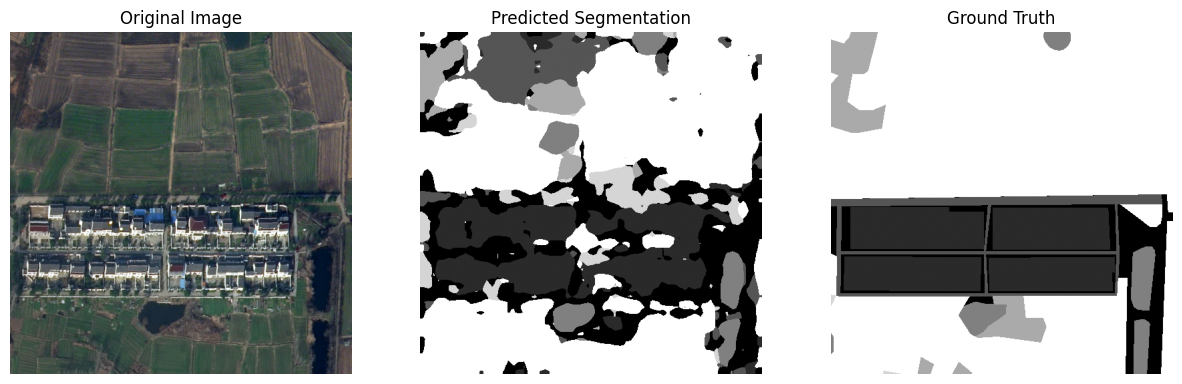

Params: 3.346 M


In [65]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    outputs = outputs[0]

    latency = end - start


    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(outputs, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = outputs.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")
